In [41]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [42]:
df = pd.read_csv('creditcard.csv')
print(df.shape,df.columns,df[df['Class'] == 1].shape,df[df['Class'] == 0].shape)

(284807, 31) Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object') (492, 31) (284315, 31)


In [44]:
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [108]:
predictors = df.drop('Class',axis = 1)
result = df['Class']
print(predictors.shape,result.shape,result[result == 0].shape,result[result == 1].shape)

(284807, 30) (284807,) (284315,) (492,)


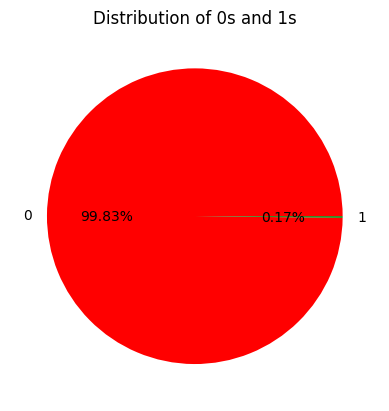

In [46]:
import matplotlib.pyplot as plt
labels = ['0','1']
plt.pie(result.value_counts(),autopct = '%1.2f%%', labels = labels,colors = ['red','green'])
#plt.pie(result,autopct = '%1.2f%%', colors = ['red','green'])
plt.title('Distribution of 0s and 1s')
plt.show()

##Random Undersampling

In [47]:
predictors = predictors[result.notnull()]
result = result[result.notnull()]

In [19]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 4.7 MB/s eta 0:00:00


In [48]:
print(result[result == 1].shape,result[result == 0].shape)

(492,) (284315,)


In [56]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 42,sampling_strategy = 0.996)
predictors_rus, result_rus = rus.fit_resample(predictors,result)

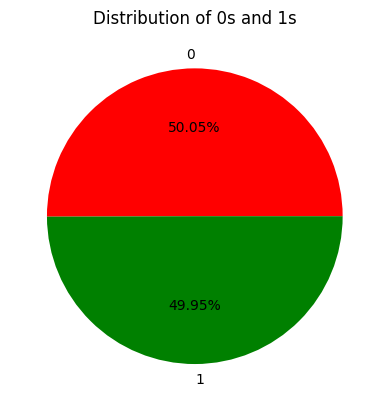

In [57]:
plt.pie(result_rus.value_counts(),autopct = '%1.2f%%', labels = labels,colors = ['red','green'])
plt.title('Distribution of 0s and 1s')
plt.show()

In [59]:
print(predictors_rus.shape,result_rus.shape,result_rus[result_rus == 0].shape,result_rus[result_rus == 1].shape)

(985, 30) (985,) (493,) (492,)


In [60]:
result_rus.value_counts()

,count
Class,
0,493
1,492


##Training the Model

In [96]:
p_train,p_test,r_train,r_test = train_test_split(predictors_rus,result_rus,test_size = 0.2,random_state = 42)

###Test train sets of the original models without undersampling for later testing

In [111]:
p_train_org,p_test_org,r_train_org,r_test_org = train_test_split(predictors,result,test_size = 0.2,random_state = 42,stratify = result)
print(r_test_org[r_test_org == 0].shape,r_test_org[r_test_org == 1].shape,r_test_org.shape)

(56864,) (98,) (56962,)


In [131]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100,class_weight = 'balanced',random_state = 42)
model.fit(p_train,r_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [132]:
ans = model.predict(p_test)
print(type(ans),ans.shape)
print(type(r_test),r_test.shape)
#original accuracy
ans_org = model.predict(p_test_org)

<class 'numpy.ndarray'> (197,)
<class 'pandas.core.series.Series'> (197,)


##Checking the Accuracy of the Model

In [133]:
ac = accuracy_score(np.array(r_test),ans)
cm = confusion_matrix(np.array(r_test),ans)
print(ac,cm)
#accuracy on orginal data
ac_org = accuracy_score(np.array(r_test_org),ans_org)
cm_org = confusion_matrix(np.array(r_test_org),ans_org)
print(ac_org,cm_org)

0.934010152284264 [[95  4]
 [ 9 89]]
0.9705066535585127 [[55187  1677]
 [    3    95]]


In [129]:
print(r_test.shape,ans.shape)

(197,) (197,)


###Improving the Model using Hyperparameter tuning(RandomSeacrchCV)

In [147]:
#creating hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 100,stop = 500,num = 10)]
max_features = ['log2','sqrt',None]
max_depth = [int(x) for x in np.linspace(10,100,num = 10)]
max_depth.append(None)
min_samples_split = [2,3,4]
min_samples_leaf = [1,2,3]
bootstrap = [True,False]
#max_features = ['log2','sqrt',None] log2 - log2(total_features) in each split, sqrt = sqrt(total_features) in each split, None = All features in each split
#min_samples_split and min_samples_leaf decide how deep the trees would go in splitting thus focusing on the minority class more

In [148]:
#create param grid
param_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf,
              'bootstrap':bootstrap}
print(param_grid)

{'n_estimators': [100, 144, 188, 233, 277, 322, 366, 411, 455, 500], 'max_features': ['log2', 'sqrt', None], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [True, False]}


In [149]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
hp_model = RandomForestClassifier()
hp_random = RandomizedSearchCV(estimator = hp_model,param_distributions = param_grid,n_iter = 25,cv = 10,verbose = 2,scoring = 'f1',random_state = 42,n_jobs = 4)
#estimator = The machine learning model you want to tune.
#param_distributions = dictionary of hyperparamters
#n_iter = The number of random combinations of hyperparameters to try.
#cv = The number of folds for cross-validation (here, 10 means 10-fold cross-validation).
#verbose = Controls the verbosity of the output during the search. 0 - Silent , 1 - Display limited info, 2 - Display full info
#random_state = A seed to ensure reproducibility of the random selection process.
#n_jobs = The number of CPU cores to use for parallel processing. -1 - Use all cores, 4 - Use 4 cores to speed up search depending on system
#scoring = 'f1'

In [155]:
#precision = measures how many transactions predicted as fraudulent are actually fraudulent.
# Recall = measures how many fraudulent transactions are correctly identified
#F1-score is the harmonic mean of precision and recall, balancing both aspects.

In [151]:
hp_model.fit(p_train,r_train)

RandomForestClassifier()

In [152]:
hp_random.fit(p_train,r_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=25,
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['log2', 'sqrt', None],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [100, 144, 188, 233,
                                                         277, 322, 366, 411,
                                                         455, 500]},
                   random_state=42, scoring='f1', verbose=2)

In [153]:
hp_random_best = hp_random.best_estimator_    #selecting the best tuned model of hp_random
print(hp_random.best_params_)

{'n_estimators': 366, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}


In [154]:
rnd_pred = hp_random_best.predict(p_test)
print(accuracy_score(r_test,rnd_pred))
print(confusion_matrix(r_test,rnd_pred))
#orginal accuracy of tuned model
rnd_pred_org = hp_random_best.predict(p_test_org)
print(accuracy_score(r_test_org,rnd_pred_org))
print(confusion_matrix(r_test_org,rnd_pred_org))


#as seen imporved accuracy on the original data

0.9390862944162437
[[95  4]
 [ 8 90]]
0.9699448755310558
[[55154  1710]
 [    2    96]]


In [146]:
# Evaluate the tuned model on training data
train_pred = hp_random_best.predict(p_train_org)
train_accuracy = accuracy_score(r_train_org, train_pred)
print("Training Accuracy (Tuned Model):", train_accuracy)

# For the default model
default_train_pred = hp_model.predict(p_train)
default_train_accuracy = accuracy_score(r_train, default_train_pred)
print("Training Accuracy (Default Model):", default_train_accuracy)


Training Accuracy (Tuned Model): 0.9748249906734842
Training Accuracy (Default Model): 1.0


In [125]:
print(type(hp_random),type(hp_model),type(hp_random_best))

<class 'sklearn.model_selection._search.RandomizedSearchCV'> <class 'sklearn.ensemble._forest.RandomForestClassifier'> <class 'sklearn.ensemble._forest.RandomForestClassifier'>
